# Retrieval with Known Answer (Plus Some Noise)

In this notebook (which is a near-copy of "Retrieval with Known Answer"), we will set up a simulated TTV system, where the answer is known. We will add some noise to this data, and sample it randomly. We will then run `ttvnest` on the final simulated data and verify that we recover a good solution. First, we import necessary packages:

In [1]:
%matplotlib inline
import ttvnest
import numpy as np

Now we set up our simulation by running a forward model on a dummy `ttvnest` simulation. This is a two planet system in which both planets transit. Planet one has $$M_1/M_\star = 4\ M_\mathrm{Earth}/M_\mathrm{Sun}, P_1 = 10.0\ \mathrm{days}, e_1\cos\omega_1 = 0.02, e_1\sin\omega_1 = 0.01, T_{0,1} = 2.0\ \mathrm{days}.$$ Planet two has $$M_2/M_\star = 6\ M_\mathrm{Earth}/M_\mathrm{Sun}, P_2 = 15.2\ \mathrm{days}, e_2\cos\omega_2 = 0.025, e_2\sin\omega_2 = 0.015, T_{0,2} = 5.0\ \mathrm{days}.$$ By default, the planets are set to be coplanar. Notice that the system is close to a 3:2 mean-motion resonance, so that we get a nice-looking TTV curve. Note also that, by default, the time system here is referenced to BJD - 2454900 (such that $T_{0,1}$ is at BJD = 2454902.0, for example). This can be changed by changing the `start_time` variable when initializing a `TTVSystem`. In this simple test, the data are homoskedastic with $\sigma = 2\times10^{-4}$ days = 0.288 min.

To make this a bit more interesting, we will perturb the exact transit timing solution with timing noise drawn from $\mathcal{N}(0, \sigma)$, and we will sample the data unevenly.

In [2]:
theta = [4., 10., 0.02, 0.01, 2., 6., 15.2, 0.025, 0.015, 5.]
perturbation_scale = 2e-4

planet_a = ttvnest.TTVPlanet([2.], [1.], [0]) #these are dummy arrays for the ttvs, errors, and observation epochs
planet_b = ttvnest.TTVPlanet([5.], [1.], [0]) #these are dummy arrays for the ttvs, errors, and observation epochs
system = ttvnest.TTVSystem(planet_a, planet_b)

data = system.forward_model(theta) #runs for 1000 days by default
perturbation = [np.random.normal(0., perturbation_scale, arr.shape) for arr in data]
data += perturbation
errs = [np.ones(arr.shape)*perturbation_scale for arr in data]
epochs = [np.arange(len(arr)) for arr in data]

#uneven sampling
for i in range(49):
    selection = np.random.randint(0, len(data[0]) - 1)
    data[0] = np.delete(data[0], selection)
    errs[0] = np.delete(errs[0], selection)
    epochs[0] = np.delete(epochs[0], selection)
    
for i in range(29):
    selection = np.random.randint(0, len(data[1]) - 1)
    data[1] = np.delete(data[1], selection)
    errs[1] = np.delete(errs[1], selection)
    epochs[1] = np.delete(epochs[1], selection)

system.data = data
system.errs = errs
system.epochs = epochs

Let's visualize how these TTV data look (when the best-fit period is detrended):

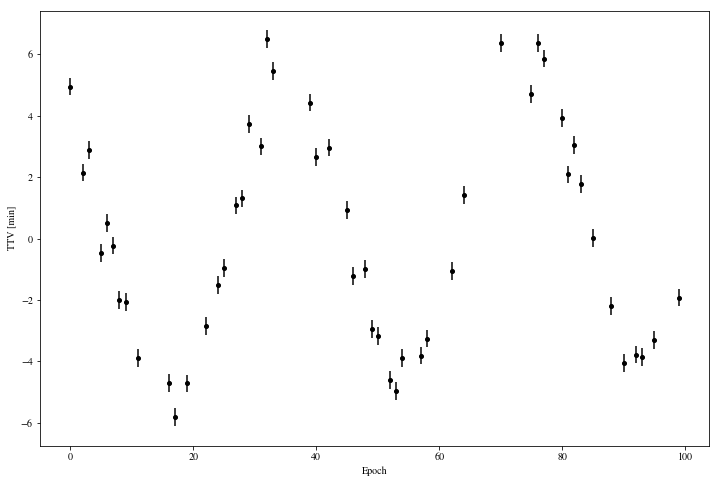

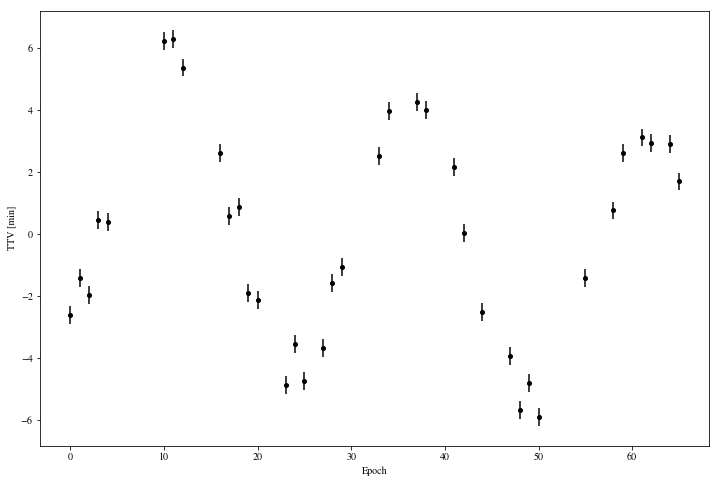

In [3]:
ttvnest.plot_utils.plot_ttv_data(system)

Looks more like real data. Still very visibly anticorrelated TTV signals as we would expect, with chopping thrown in for good measure (the synodic timescale here is $(P_1^{-1} - P_2^{-1})^{-1} = 29.2$ days, so we get chopping on about three epoch timescales for the first planet and about two epoch timescales for the second). Should be a good test case to run a retrieval on!

For our retrieval, we set up two ``TTVPlanet`` objects, initialized with arrays of transit timing data, errors, and observation epochs (where the first transit should be epoch 0). This last array is important as it will account for gaps in observation baseline. We can also pretty reliably guess that the average periods are around 10 days and 15.2 days for the planets, so we update the period prior with that knowledge. We'll also assume (to make the run time a bit nicer), that someone has done some first-order TTV theory and shown that the masses are small, so we'll use a uniform prior between 0 and 10 earth masses (relative to the stellar mass) for both planets. Finally, since for unevenly sampled data the first transit might not be close to the selected dynamical epoch, we'll use our own guess for ``t0_prior``.

We then put these planets into a ``TTVSystem``. We will let the simulation here run a bit longer than the default 1000 days to be safe (since there are probably transits near that 1000 day mark in the data above that we don't want to mess up). Be aware that increasing ``sim_length`` directly impacts the runtime, though. (The same is true for decreasing the ``TTVFast`` timestep ``dt`` when initializing a ``TTVSystem``; here I've chosen to stick with the default 0.1 day timestep. In general this should not be larger than 1/20 the smallest orbital period in consideration.)

In [4]:
planet_a = ttvnest.TTVPlanet(data[0], errs[0], epochs[0], mass_prior = ('Uniform', 0, 30.), 
                     period_prior = ('Normal', 10., 0.01),
                     t0_prior = ('Normal', data[0][0] - epochs[0][0]*10., errs[0][0]))

planet_b = ttvnest.TTVPlanet(data[1], errs[1], epochs[1], mass_prior = ('Uniform', 0, 30.), 
                     period_prior = ('Normal', 15.2, 0.01),
                     t0_prior = ('Normal', data[1][0] - epochs[1][0]*15.2, errs[1][0]))
system = ttvnest.TTVSystem(planet_a, planet_b, sim_length = 1100)


Before we run our retrieval, let's check what the theoretical maximum for the log-likelihood is using our known solution:

In [5]:
system.log_likelihood(theta, data, errs, epochs)

625.3842398626821

Finally, let's run our retrieval! The ``retrieve`` function takes an argument ``retriever``. The default sampler I've chosen is the ``DynamicNestedSampler`` from ``dynesty``. I support the ``NestedSampler`` from that package as well, but have found the ``DynamicNestedSampler`` to do a better job at estimating the posterior for TTV retrieval problems (as it's designed to do with the right weight and stopping functions). If you pass in any supported keyword arguments for either of the supported nested samplers, the function will pass it on to ``dynesty`` (other non-recognized keyword arguments will be ignored).

In [6]:
results = system.retrieve()

40663it [2:08:47,  5.07it/s, batch: 0 | bound: 260 | nc: 25 | ncall: 984461 | eff(%):  4.126 | loglstar:   -inf < 620.404 <    inf | logz: 580.019 +/- 521.276 | dlogz:  5.142 >  0.010]          /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/usr/local/lib/python3.7/site-packages/dynesty/sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
43158it [2:18:05,  4.56it/s, batch: 0 | bound: 278 | nc: 25 | ncall: 1057014 | eff(%):  4.079 | loglstar:   -inf < 623.067 <    inf | logz: 581.227 +/- 521.276 | dlogz:  2.101 >  0.010] /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the s

/usr/local/lib/python3.7/site-packages/dynesty/sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
50272it [3:01:59,  5.80it/s, batch: 0 | bound: 343 | nc: 25 | ncall: 1410356 | eff(%):  3.562 | loglstar:   -inf < 626.825 <    inf | logz: 581.778 +/- 521.276 | dlogz:  0.038 >  0.010]   /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/usr/local/lib/python3.7/site-packages/dynesty/sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
50722it [3:05:01,  5.60it/s, batch: 0 | bound: 347 | nc: 25 | ncall: 1434865 | eff(%):  3.533 | loglstar:   -inf < 62

We finished with a best log-likelihood that's higher than the solution...makes sense because we added some noise. Let's get a summary of our results in $\LaTeX$-friendly format:

In [7]:
system.posterior_summary()

Summary (middle 95 percentile): 
$M_1/M_\star$: $4.335328^{+0.402798}_{-0.382269}$
$P_1\ [\mathrm{days}]$: $9.999834^{+0.000136}_{-0.00013}$
$e_1\cos(\omega_1)$: $0.036755^{+0.020257}_{-0.036701}$
$e_1\sin(\omega_1)$: $0.041598^{+0.044508}_{-0.021306}$
$T_{0,1}\ [\mathrm{days}]$: $1.999937^{+0.000116}_{-0.000184}$
$M_2/M_\star$: $6.485388^{+0.623452}_{-0.556824}$
$P_2\ [\mathrm{days}]$: $15.200251^{+0.000212}_{-0.000217}$
$e_2\cos(\omega_2)$: $0.038194^{+0.016737}_{-0.029965}$
$e_2\sin(\omega_2)$: $0.04072^{+0.03623}_{-0.017478}$
$T_{0,2}\ [\mathrm{days}]$: $4.999977^{+0.000104}_{-0.000116}$


The solution above is within the middle 95% of our retrieved posterior. Let's see how the best-fit solution and uncertainty look, for good measure:

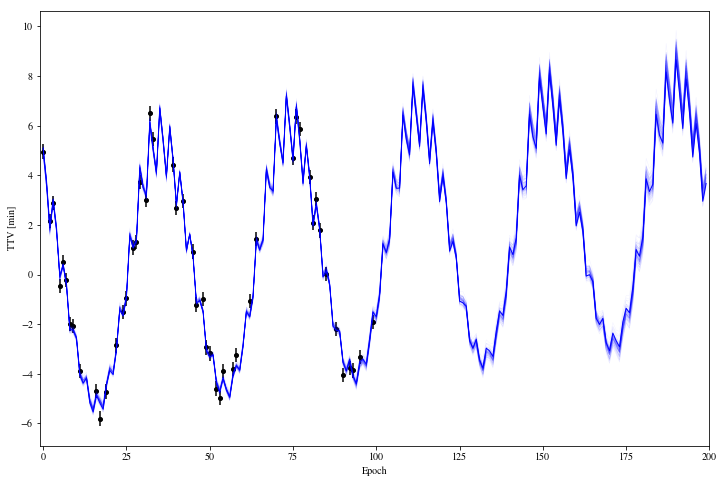

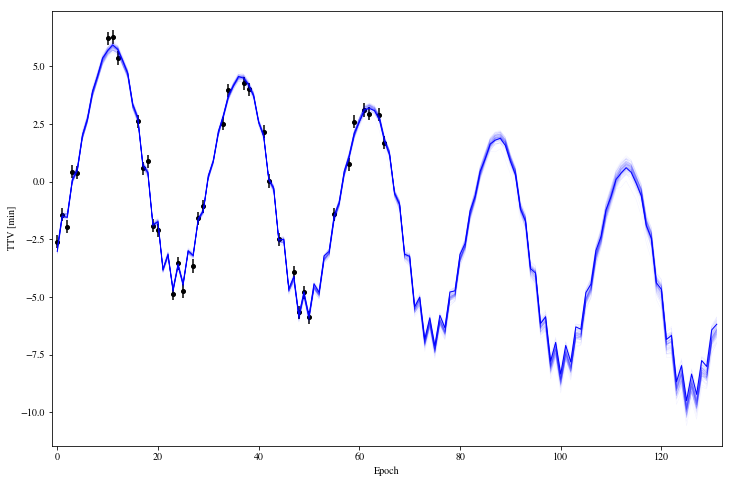

In [8]:
ttvnest.plot_utils.plot_results(system, uncertainty_curves = 100, sim_length = 2000)

With a hundred random draws from the posterior, it looks like we have a really solid constraint on the timing curve (even if the best solution we got isn't *exactly* the known answer). 

Finally, let's look at the corner plots (for viewing the marginalized posteriors) and trace plot (showing the evolution of all parameters over the run) from ``dynesty``:

<Figure size 1440x1440 with 0 Axes>

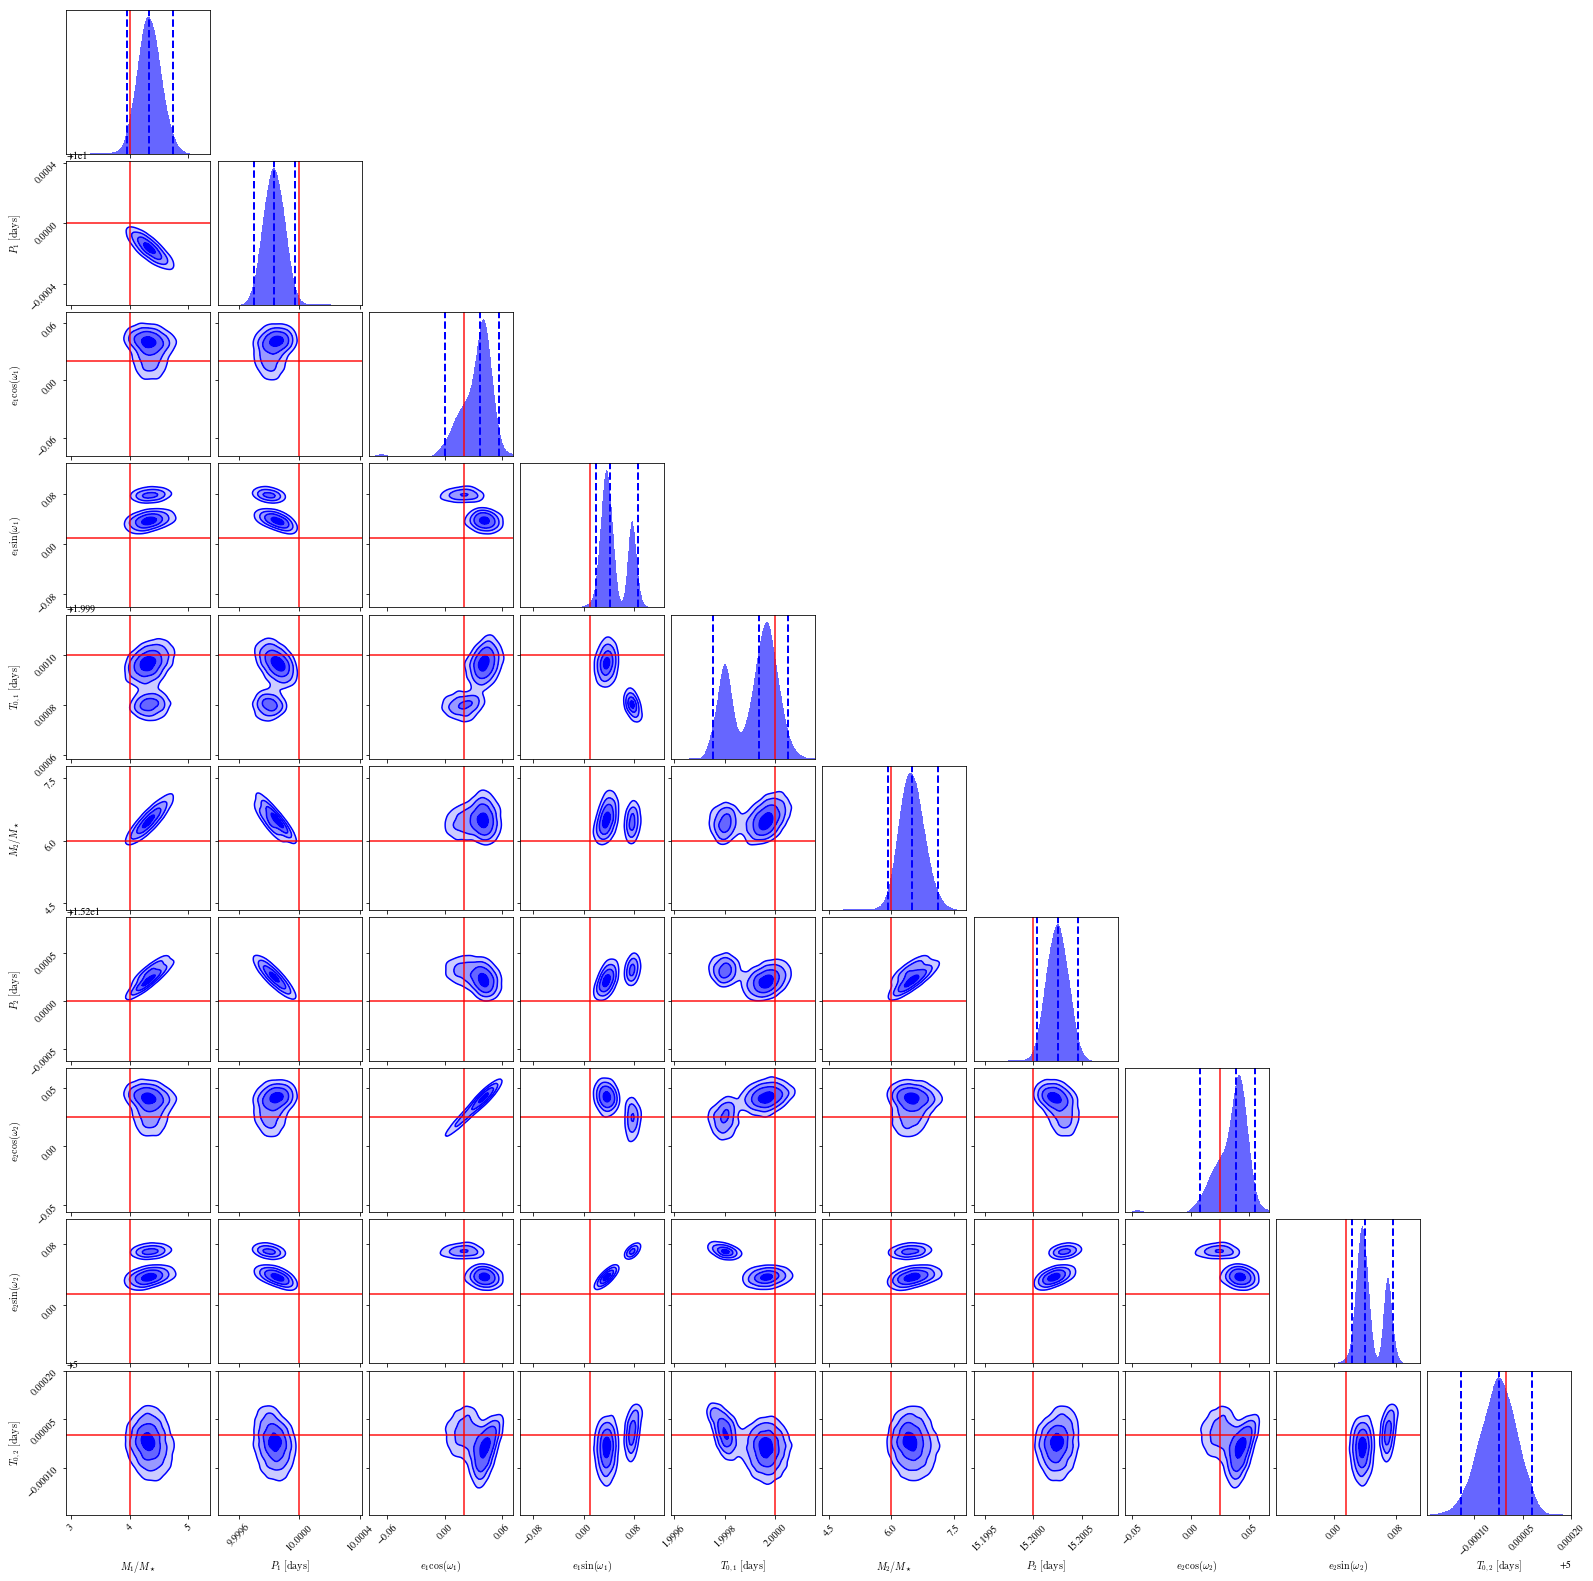

<Figure size 1440x1440 with 0 Axes>

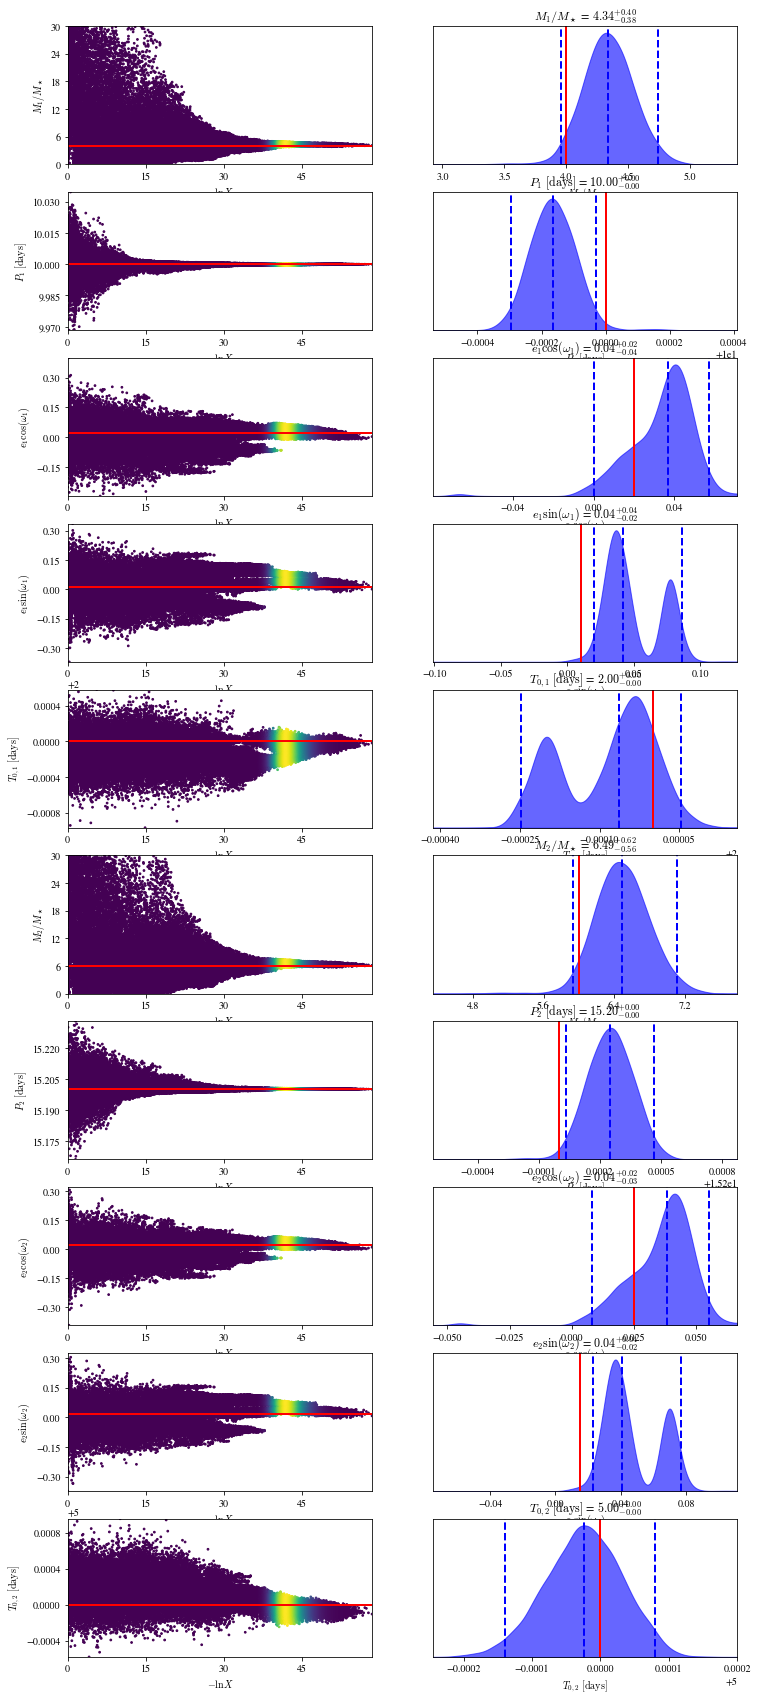

In [9]:
ttvnest.plot_utils.dynesty_plots(system, truthvals = theta)

Pretty decent constraints, considering the noise and poor sampling!